In [ ]:
! pip install qiskit

In [55]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import numpy as np

In [43]:
def num2bits(num, nbits):
  '''
  Convert num to nbit string
  '''
  formt = '{0:0'+str(nbits)+'b}'
  return formt.format(int(num))

def QFT_Bare(nbits):
  '''
  Bare circuit of QFT
  '''

  # Create Quantum Circuit
  qft_circ = QuantumCircuit(nbits)
  # Push phase to product state
  for idx in range(nbits-1,-1,-1):
    # Append Hadamard to target qbit
    qft_circ.h(idx)
    # Append Rk gates
    for tdx in range(idx):
      qft_circ.cu1(2.0*np.pi/2**(idx+1-tdx),tdx,idx)
    qft_circ.barrier()
  # Swap states j and n-j-1
  for idx in range(nbits//2):
    qft_circ.swap(idx,nbits-idx-1)
  # Return circuit
  return qft_circ

def PushPhase(jbit):
  '''
  Gate for pushing phas on jbit's
  subsystem of product state in QFT
  '''

  # Create Quantum Circuit
  entry = QuantumCircuit(jbit+1)
  # Append Hadamard to target qbit
  entry.h(jbit)
  # Append Rk gates
  for idx in range(jbit):
    entry.cu1(2.0*np.pi/2**(jbit+1-idx),idx,jbit)
  # Convert circuit to gate
  pp_gate = entry.to_gate()
  pp_gate.name = 'PushPhase'+str(jbit)
  return pp_gate

def QFT_circ(nbits):
  '''
  Abbreviated quantum circuit
  for computing QFT
  '''

  # Create Quantum Circuit
  qft_circ = QuantumCircuit(nbits)
  # Push phase to product state
  for idx in range(nbits-1,-1,-1):
    PPgate = PushPhase(idx)
    qft_circ.append(PPgate,range(idx+1))
  #qft_circ.barrier()
  # Swap states j and n-j-1
  for idx in range(nbits//2):
    qft_circ.swap(idx,nbits-idx-1)
  # Return circuit
  return qft_circ

def QFT_dg_circ(nbits):
  '''
  Abbreviated quantum circuit
  for computing inverse QFT
  '''

  # Create Quantum Circuit
  qft_circ = QuantumCircuit(nbits)
  # Swap states j and n-j-1
  for idx in range(nbits//2):
    qft_circ.swap(idx,nbits-idx-1)
  # Pull phase from product state
  for idx in range(nbits):
    # Append Rk gates
    for tdx in range(idx):
      qft_circ.cu1(-2.0*np.pi/2**(idx+1-tdx),tdx,idx)
    # Append Hadamard to target qbit
    qft_circ.h(idx)
  # Return circuit
  return qft_circ

def QFT(nbits):
  '''
  QFT gate
  '''

  qft_circ = QFT_circ(nbits)
  qft_gate = qft_circ.to_gate()
  qft_gate.name = 'QFT'
  return qft_gate

def QFT_dg(nbits):
  '''
  Inverse QFT gate
  '''
  
  qft_circ = QFT_dg_circ(nbits)
  qft_gate = qft_circ.to_gate()
  qft_gate.name = 'QFTdg'
  return qft_gate

In [82]:
n = 3
inum = 5

In [83]:
mycirc = QuantumCircuit(n)
# Initialise with nbit number
input_state = num2bits(inum,n)
for idx in range(n-1,-1,-1):
  if input_state[idx] == '1':
    mycirc.x(n-1-idx)
mycirc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

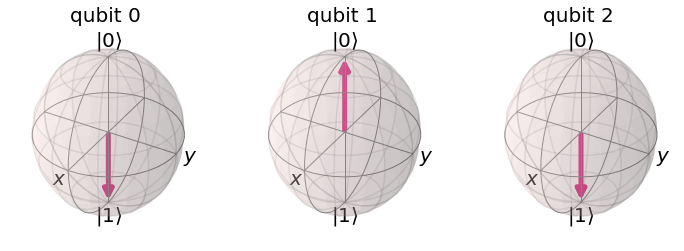

In [84]:
backend = Aer.get_backend('statevector_simulator')
input_state = execute(mycirc,backend=backend).result().get_statevector()
plot_bloch_multivector(input_state)

In [85]:
mycirc.append(QFT(n),range(n))
# mycirc.append(QFT_dg(n),range(n))
mycirc.draw()

┌───┐┌──────┐
q_0: ┤ X ├┤0     ├
     └───┘│      │
q_1: ─────┤1 QFT ├
     ┌───┐│      │
q_2: ┤ X ├┤2     ├
     └───┘└──────┘

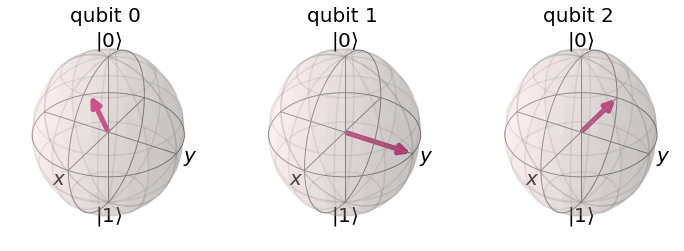

In [86]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(mycirc,backend=backend).result().get_statevector()
plot_bloch_multivector(final_state)